**Imports & Setup**

In [21]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# directories & file paths
TRAIN_DIR = Path("../../data/processed_balanced/train")
IMG_DIR = Path("../../data/processed")
VAL_DIR   = IMG_DIR / "validate"
TEST_DIR  = IMG_DIR / "test"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")
RESULTS_DIR = Path("./results")
RESULTS_PATH = RESULTS_DIR / "knn_results.csv"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# target styles for classification
TARGET_STYLES = [
    "Abstract_Expressionism",
    "Baroque",
    "Cubism",
    "Impressionism",
    "Pop_Art"
]

**Extracting Features**

In [10]:
# config for data loading & feature extraction
BATCH = 64
AUTO  = tf.data.AUTOTUNE
EXPECT_SIZE = (256, 256)
STRICT_SIZE = True

# mapping from class name to label index
CLASS_TO_IDX = {c:i for i,c in enumerate(TARGET_STYLES)}
def list_paths_labels(root: Path):
    paths, labels = [], []
    for cls in TARGET_STYLES:
        cls_dir = root / cls
        if not cls_dir.exists(): 
            continue
        for p in sorted(cls_dir.rglob("*")):
            if p.suffix.lower() in EXTS and p.is_file():
                paths.append(str(p))
                labels.append(CLASS_TO_IDX[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

def decode_keep_size(path):
    '''
    decode image from path, keep 224 size if STRICT_SIZE is true
    '''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    if STRICT_SIZE:
        shape = tf.shape(img)
        assert_op = tf.debugging.assert_equal(shape[:2], EXPECT_SIZE, message="Non-224 image found")
        with tf.control_dependencies([assert_op]):
            img = tf.identity(img)
    img = tf.cast(img, tf.float32)
    img = resnet50.preprocess_input(img)
    return img

def build_ds(paths, labels=None, shuffle=False):
    '''
    build tf.data.Dataset from image paths & labels
    '''
    x = tf.data.Dataset.from_tensor_slices(paths)
    x = x.map(decode_keep_size, num_parallel_calls=AUTO)
    if labels is not None:
        y = tf.data.Dataset.from_tensor_slices(labels)
        ds = tf.data.Dataset.zip((x, y))
    else:
        ds = x
    if shuffle:
        ds = ds.shuffle(buffer_size=min(10000, len(paths)), seed=42, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

# load backbone model from keras applications
backbone = resnet50.ResNet50(include_top=False, weights="imagenet", pooling="avg")
train_paths, y_train = list_paths_labels(TRAIN_DIR)
val_paths,   y_val   = list_paths_labels(VAL_DIR)
test_paths,  y_test  = list_paths_labels(TEST_DIR)

# build datasets
train_ds = build_ds(train_paths, y_train, shuffle=False)
val_ds = build_ds(val_paths, y_val, shuffle=False)
test_ds = build_ds(test_paths, y_test, shuffle=False)

# extract features
X_train = backbone.predict(train_ds, verbose=1)
X_val = backbone.predict(val_ds, verbose=1)
X_test = backbone.predict(test_ds, verbose=1)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

2025-10-28 20:56:15.179871: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.
2025-10-28 20:56:15.330426: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 276889600 exceeds 10% of free system memory.
2025-10-28 20:56:15.442511: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.
2025-10-28 20:56:15.575881: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.
2025-10-28 20:56:15.822008: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 268435456 exceeds 10% of free system memory.


235/235 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Shapes: (15000, 2048) (4760, 2048) (4761, 2048)


**K-NN Model**

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'} , Best CV MCC: 0.8893589835643861


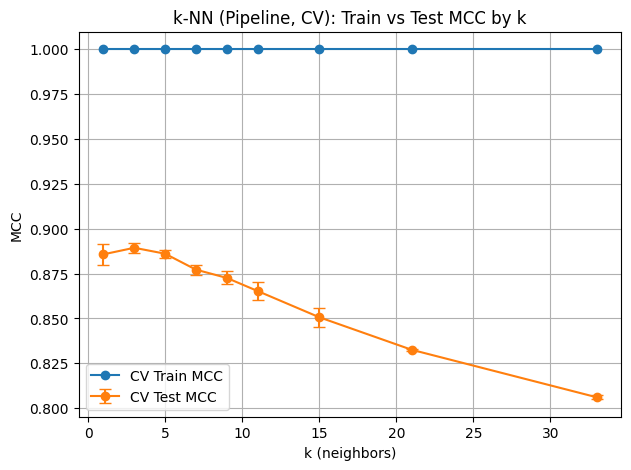

VAL MCC: 0.7431977955806747 , ACCURACY: 0.8222689075630252
TEST MCC: 0.7479798154669032 , ACCURACY: 0.8271371560596513

Test classification report:
                        precision    recall  f1-score   support

Abstract_Expressionism       0.77      0.72      0.74       557
               Baroque       0.67      0.96      0.79       848
                Cubism       0.72      0.81      0.77       447
         Impressionism       0.97      0.84      0.90      2612
               Pop_Art       0.67      0.60      0.63       297

              accuracy                           0.83      4761
             macro avg       0.76      0.78      0.76      4761
          weighted avg       0.85      0.83      0.83      4761


Confusion matrix (test):
[[ 400   22   54   27   54]
 [   2  815    5   26    0]
 [  28   17  363   17   22]
 [  34  342   41 2183   12]
 [  56   16   39    9  177]]


In [24]:
# hyperparameters for knn grid search
K_GRID = [1, 3, 5, 7, 9, 11, 15, 21, 33]
RANDOM_STATE = 635

# create pipeline for scaling + knn grid
pipe = Pipeline([("norm", Normalizer(norm="l2")), ("knn", KNeighborsClassifier(metric="cosine", weights="distance", algorithm="brute"))])
param_grid = {"knn__n_neighbors": K_GRID, "knn__weights": ["uniform", "distance"]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
mcc_scorer = make_scorer(matthews_corrcoef)

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring=mcc_scorer, return_train_score=True, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

# save results to csv
gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
cv_csv = RESULTS_PATH
gs_df.to_csv(cv_csv, index=False)
print("Best parameters:", gs.best_params_, ", Best CV MCC:", gs.best_score_)

# plot scores of different k values
rows = [np.where(gs_df['param_knn__n_neighbors'] == k)[0][0] for k in K_GRID]
mean_test = gs_df.iloc[rows]["mean_test_score"].values
std_test  = gs_df.iloc[rows]["std_test_score"].values
mean_train = gs_df.iloc[rows]["mean_train_score"].values
plt.figure(figsize=(7,5))
plt.plot(K_GRID, mean_train, marker='o', label='CV Train MCC')
plt.errorbar(K_GRID, mean_test, yerr=std_test, marker='o', capsize=4, label='CV Test MCC')
plt.xlabel('k (neighbors)')
plt.ylabel('MCC')
plt.title('k-NN (Pipeline, CV): Train vs Test MCC by k')
plt.grid(True)
plt.legend()
plot_path = RESULTS_DIR / "knn_plot.png"
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

# evaluate best k value pipeline on test
best_model = gs.best_estimator_
val_pred  = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

# print evaluation metrics
print("VAL MCC:", matthews_corrcoef(y_val,  val_pred), ", ACCURACY:", accuracy_score(y_val,  val_pred))
print("TEST MCC:", matthews_corrcoef(y_test, test_pred), ", ACCURACY:", accuracy_score(y_test, test_pred))
print("\nTest classification report:")
print(classification_report(y_test, test_pred, target_names=TARGET_STYLES))
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, test_pred))